# Get started with Flower
Welcome to the Flower federated learning tutorial!

In this notebook, we’ll build a federated learning system using the Flower framework, Flower Datasets and PyTorch. In part 1, we use PyTorch for the model training pipeline and data loading. In part 2, we federate the PyTorch project using Flower.

## Step 0: Preparation

### Loading dependencies

In [1]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

/home/syed/miniconda3/envs/flwr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-07 17:10:10,570	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Training on cuda
Flower 1.20.0 / PyTorch 2.8.0+cu128


### Loading Data

In [2]:
NUM_CLIENTS = 10
BATCH_SIZE = 32

def load_datasets(partition_id: int):
    """Load datasets for a given partition ID."""
    fds = FederatedDataset(
        dataset="cifar10",
        partitioners = {
            "train": NUM_CLIENTS
        }
    )
    
    partition = fds.load_partition(partition_id)

    """Divide the partition into 80% train and 20% test sets."""

    partition_train_test = partition.train_test_split(
        train_size=0.8,
        seed=42
    )
    
    pytorch_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )

    def apply_transform(batch):
        """Instead of passing transforms to CIFAR10(..., transform=transform)
        we will use this function to dataset.with_transform(apply_transforms)
        The transforms object is exactly the same"""
        batch["img"] = [pytorch_transform(img) for img in batch["img"]]
        return batch
    
    """Create train and test datasets with the applied transforms for each partition,
    and wrap them in DataLoader."""

    partition_train_test = partition_train_test.with_transform(apply_transform)
    trainloader = DataLoader(
        partition_train_test["train"], 
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    """Create a test DataLoader without shuffling
    to ensure that the test data is processed in the same order each time.
    This is important for evaluation consistency."""
    valloader = DataLoader(
        partition_train_test["test"],
        batch_size=BATCH_SIZE,
    )

    testset = fds.load_split("test")
    testset = testset.with_transform(apply_transform)
    testloader = DataLoader(
        testset,
        batch_size=BATCH_SIZE
    )

    return trainloader, valloader, testloader

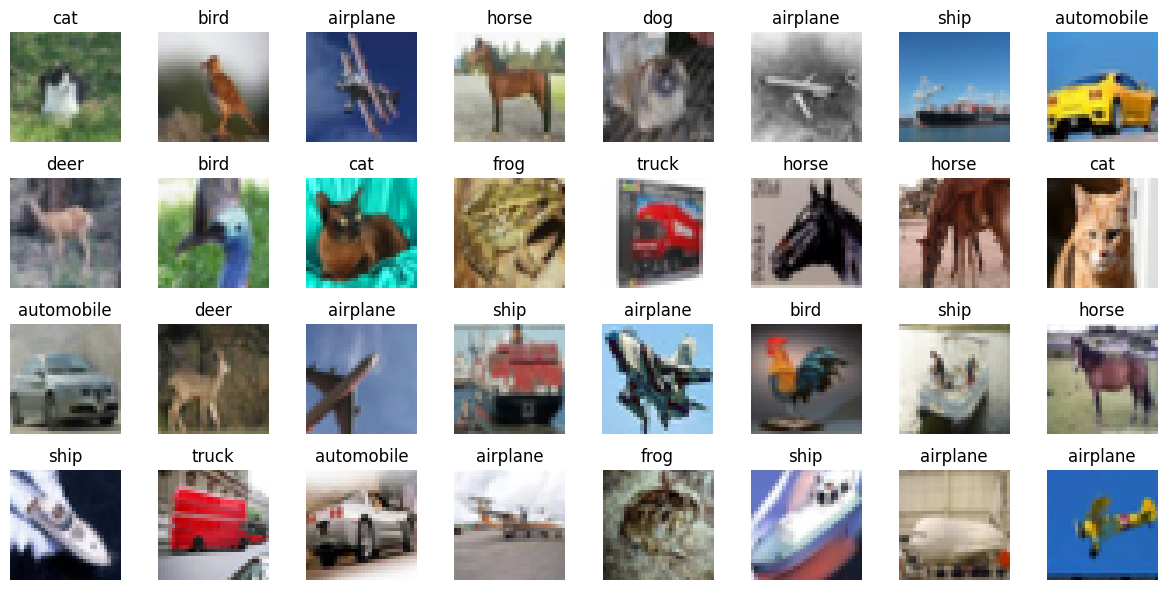

In [ ]:
trainloader, _, _ = load_datasets(0)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]
print(f"Batch size: {len(batch['img'])}, Image shape: {batch['img'][0].shape}, Label shape: {batch['label'].shape}")

# Reshape and convert images to numpy arrays for visualization
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()  # Change from (N, C, H, W) to (N, H, W, C)

# Denormalize images for better visualization
images = images / 2 + 0.5  # Reverse the normalization (0.5, 0.5, 0.5)

#Create a figure and grid of subplots
fig, axes = plt.subplots(4, 8, figsize=(12, 6))

# Loop through the first 32 images and their corresponding labels
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

## Step 1: Centralized Training with PyTorch

### Define the model

In [5]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
def train(net, trainloader, epochs: int, verbose=True):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


In [7]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

### Train the model

In [ ]:
trainloader, valloader, testloader = load_datasets(partition_id=0)
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: train loss 0.06670492887496948, accuracy 0.199
Epoch 1: validation loss 0.06110432243347168, accuracy 0.313
Epoch 1: train loss 0.057077646255493164, accuracy 0.33425
Epoch 2: validation loss 0.05483860123157501, accuracy 0.374
Epoch 1: train loss 0.05331991985440254, accuracy 0.38125
Epoch 3: validation loss 0.05595359933376312, accuracy 0.38
Epoch 1: train loss 0.05124972015619278, accuracy 0.405
Epoch 4: validation loss 0.05014273476600647, accuracy 0.435
Epoch 1: train loss 0.048849064856767654, accuracy 0.4275
Epoch 5: validation loss 0.05015324699878693, accuracy 0.44
Final test set performance:
	loss 0.05033364090919495
	accuracy 0.4229


## Step 2: Federated Learning with Flower

### Update model parameters

In [10]:
def set_parameter(net, parameters: List[np.ndarray]):
    """Set the model parameters from a list of numpy arrays."""
    param_dict = zip(net.state_dict().keys(), parameters)

    state_dict = OrderedDict({k: torch.tensor(v, dtype=torch.float32).to(DEVICE) for k, v in param_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [v.cpu().numpy() for v in net.state_dict().values()]

### Define the Flower ClientApp

The first step toward creating a ClientApp is to implement a subclasses of flwr.client.Client or flwr.client.NumPyClient. We use NumPyClient in this tutorial because it is easier to implement and requires us to write less boilerplate. To implement NumPyClient, we create a subclass that implements the three methods get_parameters, fit, and evaluate:

get_parameters: Return the current local model parameters

fit: Receive model parameters from the server, train the model on the local data, and return the updated model parameters to the server

evaluate: Receive model parameters from the server, evaluate the model on the local data, and return the evaluation result to the server

In [11]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)
    
    def fit(self, parameters, config):
        set_parameter(self.net, parameters)
        train(self.net, self.trainloader, epochs=1, verbose=True)
        return get_parameters(self.net), len(self.trainloader.dataset), {}
    
    def evaluate(self, parameters, config):
        set_parameter(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [12]:
def client_fn(context: Context) -> Client:
    """Create a Flower client."""

    # Load model
    net = Net().to(DEVICE)
    """Load datasets for the given partition ID (CIFAR-10)
    Note: each client gets a different trainloader/valloader, so each client
    will train and evaluate on their own unique data partition
    Read the node_config to fetch data partition associated to this node"""

    """ Get the partition ID from the context
    # This is set by the server when it starts the simulation
    # and is used to identify which partition of the dataset this client should use
    # The partition ID is passed to the client via the context object
    # This allows the server to assign different partitions of the dataset to different clients"""
    
    partition_id = context.node_config["partition_id"]
    """Load the datasets for the given partition ID."""
    trainloader, valloader, _ = load_datasets(partition_id)

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()

#Create the ClientApp
client = ClientApp(
    client_fn=client_fn
)